Final Project: Implementing a Model to Predict Hospital Readmission from Diabetes Diagnosis 



Brianna L. Palmisano, Jianna J. Estevez & Julianna M. Lomonte



St. John’s University, The Peter J. Tobin College of Business




BUA 611/3311: Machine Learning for Business, Professor Yanni Ping, PhD.


Data Link:
https://www.kaggle.com/datasets/dubradave/hospital-readmissions/data 

In [68]:
# Import individual packages
import pandas as pd
import numpy as np
import sklearn
from sklearn import (cluster,
                     datasets,
                     decomposition,
                     discriminant_analysis,
                     dummy,
                     ensemble,
                     feature_selection as ftr_sel,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     pipeline,
                     preprocessing as skpre,
                     svm,
                     tree)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
def rdot(w,x):
    ' apply np.dot on swapped args '
    return np.dot(x,w)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import itertools as it

In [69]:
# Initialize the MultiColumnLabelEncoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [70]:
# Load the dataset
Hospital_df = pd.read_csv("hospital_readmissions.csv")
Hospital_df

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90),14,77,1,30,0,0,0,Missing,Circulatory,Other,Circulatory,no,normal,no,no,yes
24996,[80-90),2,66,0,24,0,0,0,Missing,Digestive,Injury,Other,no,high,yes,yes,yes
24997,[70-80),5,12,0,6,0,1,0,Missing,Other,Other,Other,normal,no,no,no,yes
24998,[70-80),2,61,3,15,0,0,0,Family/GeneralPractice,Respiratory,Diabetes,Other,no,no,yes,yes,no


In [71]:
# Dropping bad data
Hospital_df_1=Hospital_df.drop('medical_specialty', axis=1)
Hospital_df_1

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,Other,Circulatory,Respiratory,no,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90),14,77,1,30,0,0,0,Circulatory,Other,Circulatory,no,normal,no,no,yes
24996,[80-90),2,66,0,24,0,0,0,Digestive,Injury,Other,no,high,yes,yes,yes
24997,[70-80),5,12,0,6,0,1,0,Other,Other,Other,normal,no,no,no,yes
24998,[70-80),2,61,3,15,0,0,0,Respiratory,Diabetes,Other,no,no,yes,yes,no


In [72]:
# Dropping missing values
#df = df[df['your_variable'] != 'missing']
Hospital_df_2 = Hospital_df_1 [Hospital_df_1['diag_1']!= 'Missing']
Hospital_df_3 = Hospital_df_2 [Hospital_df_2['diag_2']!= 'Missing']
Hospital_df_4 = Hospital_df_3 [Hospital_df_3['diag_3']!= 'Missing']
Hospital_df_4

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,Other,Circulatory,Respiratory,no,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90),14,77,1,30,0,0,0,Circulatory,Other,Circulatory,no,normal,no,no,yes
24996,[80-90),2,66,0,24,0,0,0,Digestive,Injury,Other,no,high,yes,yes,yes
24997,[70-80),5,12,0,6,0,1,0,Other,Other,Other,normal,no,no,no,yes
24998,[70-80),2,61,3,15,0,0,0,Respiratory,Diabetes,Other,no,no,yes,yes,no


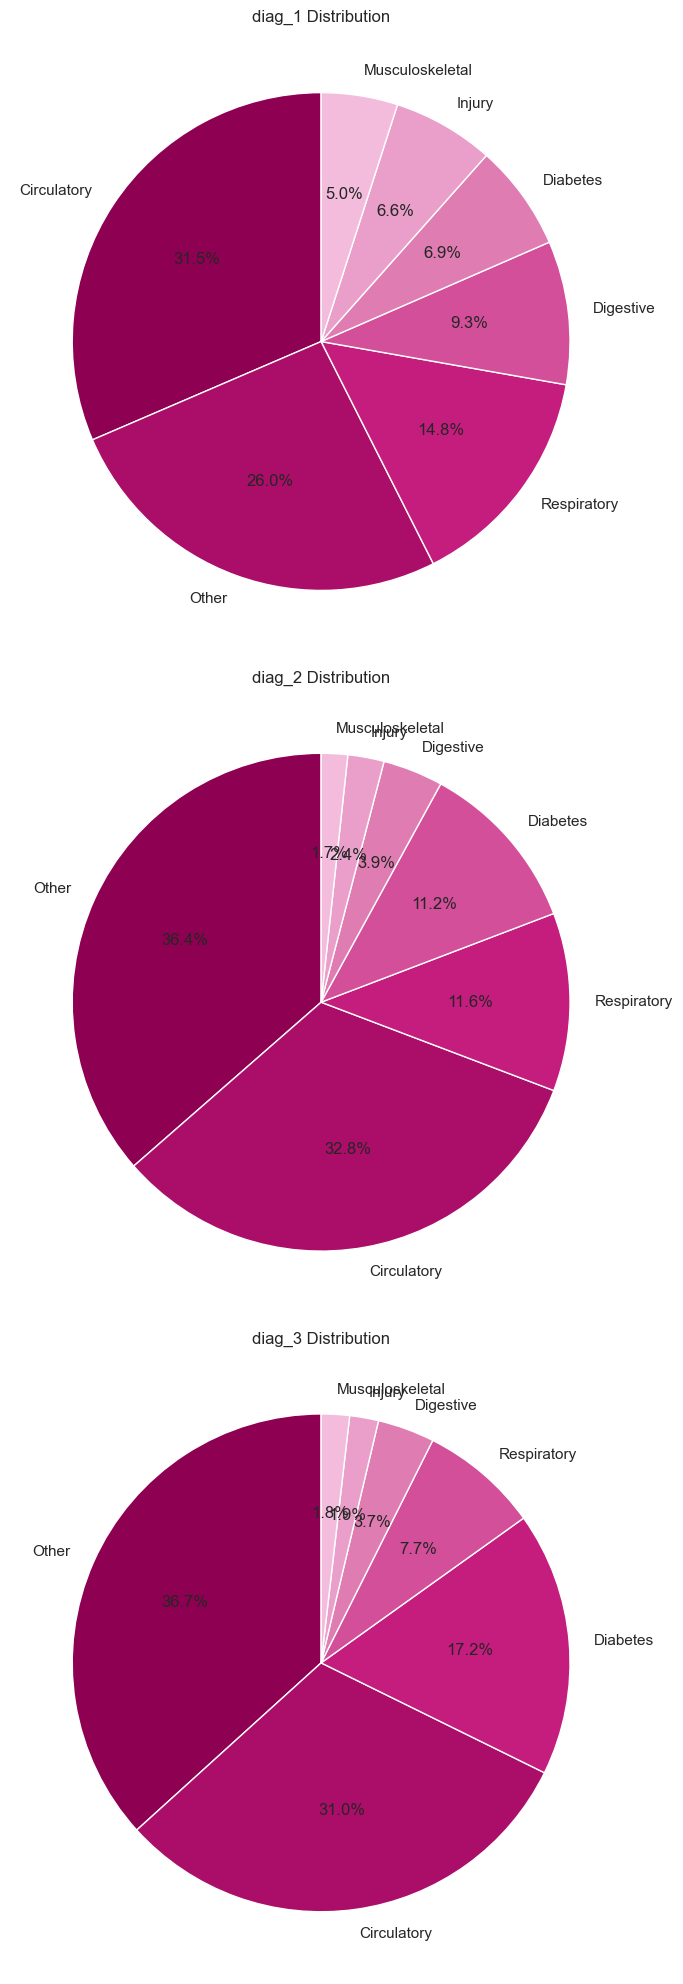

In [73]:
# Visualizing diagnosis distribution
cat_vars = ['diag_1', 'diag_2', 'diag_3']

# Create subplots for each categorical variable
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(25, 20))

# Define a custom color range transitioning from pink to green
colors = plt.cm.PiYG(np.linspace(0, 1, 20))  # Generate colors from red to yellow to green

# Iterate over each categorical variable
for i, var in enumerate(cat_vars):
    if i < len(axs.flat):  # Ensure we don't exceed the number of subplots
        # Get value counts for the categorical variable
        cat_counts = Hospital_df_4[var].value_counts()
        
        # Plot a pie chart for the current categorical variable
        axs.flat[i].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
        
        # Set title for the subplot
        axs.flat[i].set_title(f'{var} Distribution')

# Adjust layout to prevent overlapping
fig.tight_layout()
plt.show()

In [74]:
# Creating new features
mean_time_inhos = Hospital_df_4['time_in_hospital'].mean()
mean_time_inhos
Hospital_df_4['average_time_in_hospital'] = mean_time_inhos
Hospital_df_4['average_#_of_procedures']=Hospital_df_4.apply(lambda x:(x['n_procedures']+x['n_lab_procedures'])/2, axis=1)
Hospital_df_4

<ipython-input-74-8afc9698a634>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hospital_df_4['average_time_in_hospital'] = mean_time_inhos
<ipython-input-74-8afc9698a634>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Hospital_df_4['average_#_of_procedures']=Hospital_df_4.apply(lambda x:(x['n_procedures']+x['n_lab_procedures'])/2, axis=1)


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted,average_time_in_hospital,average_#_of_procedures
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,no,yes,no,4.465354,36.5
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,no,yes,no,4.465354,18.0
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes,4.465354,22.5
3,[70-80),2,36,0,12,1,0,0,Circulatory,Other,Diabetes,no,no,yes,yes,yes,4.465354,18.0
4,[60-70),1,42,0,7,0,0,0,Other,Circulatory,Respiratory,no,no,no,yes,no,4.465354,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,[80-90),14,77,1,30,0,0,0,Circulatory,Other,Circulatory,no,normal,no,no,yes,4.465354,39.0
24996,[80-90),2,66,0,24,0,0,0,Digestive,Injury,Other,no,high,yes,yes,yes,4.465354,33.0
24997,[70-80),5,12,0,6,0,1,0,Other,Other,Other,normal,no,no,no,yes,4.465354,6.0
24998,[70-80),2,61,3,15,0,0,0,Respiratory,Diabetes,Other,no,no,yes,yes,no,4.465354,32.0


In [75]:
# Encoding categorical variables
enc_df = pd.get_dummies(Hospital_df_4, columns = ['age','diag_1','diag_2','diag_3','change','diabetes_med'],dtype=float)
Hospital2_df=MultiColumnLabelEncoder(columns = ['glucose_test','A1Ctest','readmitted']).fit_transform(enc_df)
Hospital2_df

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,glucose_test,A1Ctest,readmitted,...,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,change_no,change_yes,diabetes_med_no,diabetes_med_yes
0,8,72,1,18,2,0,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,3,34,2,13,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,5,45,0,18,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2,36,0,12,1,0,0,1,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1,42,0,7,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14,77,1,30,0,0,0,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
24996,2,66,0,24,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
24997,5,12,0,6,0,1,0,2,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
24998,2,61,3,15,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [76]:
# Descriptive statistics; all features
desc_stats = Hospital2_df.describe()
print(desc_stats)

       time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
count      24779.000000      24779.000000  24779.000000   24779.000000   
mean           4.465354         43.310828      1.356512      16.295411   
std            3.004725         19.828181      1.718044       8.059673   
min            1.000000          1.000000      0.000000       1.000000   
25%            2.000000         31.000000      0.000000      11.000000   
50%            4.000000         44.000000      1.000000      15.000000   
75%            6.000000         57.000000      2.000000      20.000000   
max           14.000000        113.000000      6.000000      79.000000   

       n_outpatient   n_inpatient   n_emergency  glucose_test       A1Ctest  \
count  24779.000000  24779.000000  24779.000000  24779.000000  24779.000000   
mean       0.368296      0.619073      0.187619      0.999879      0.936559   
std        1.199068      1.180659      0.889186      0.234022      0.398068   
min        0.0000

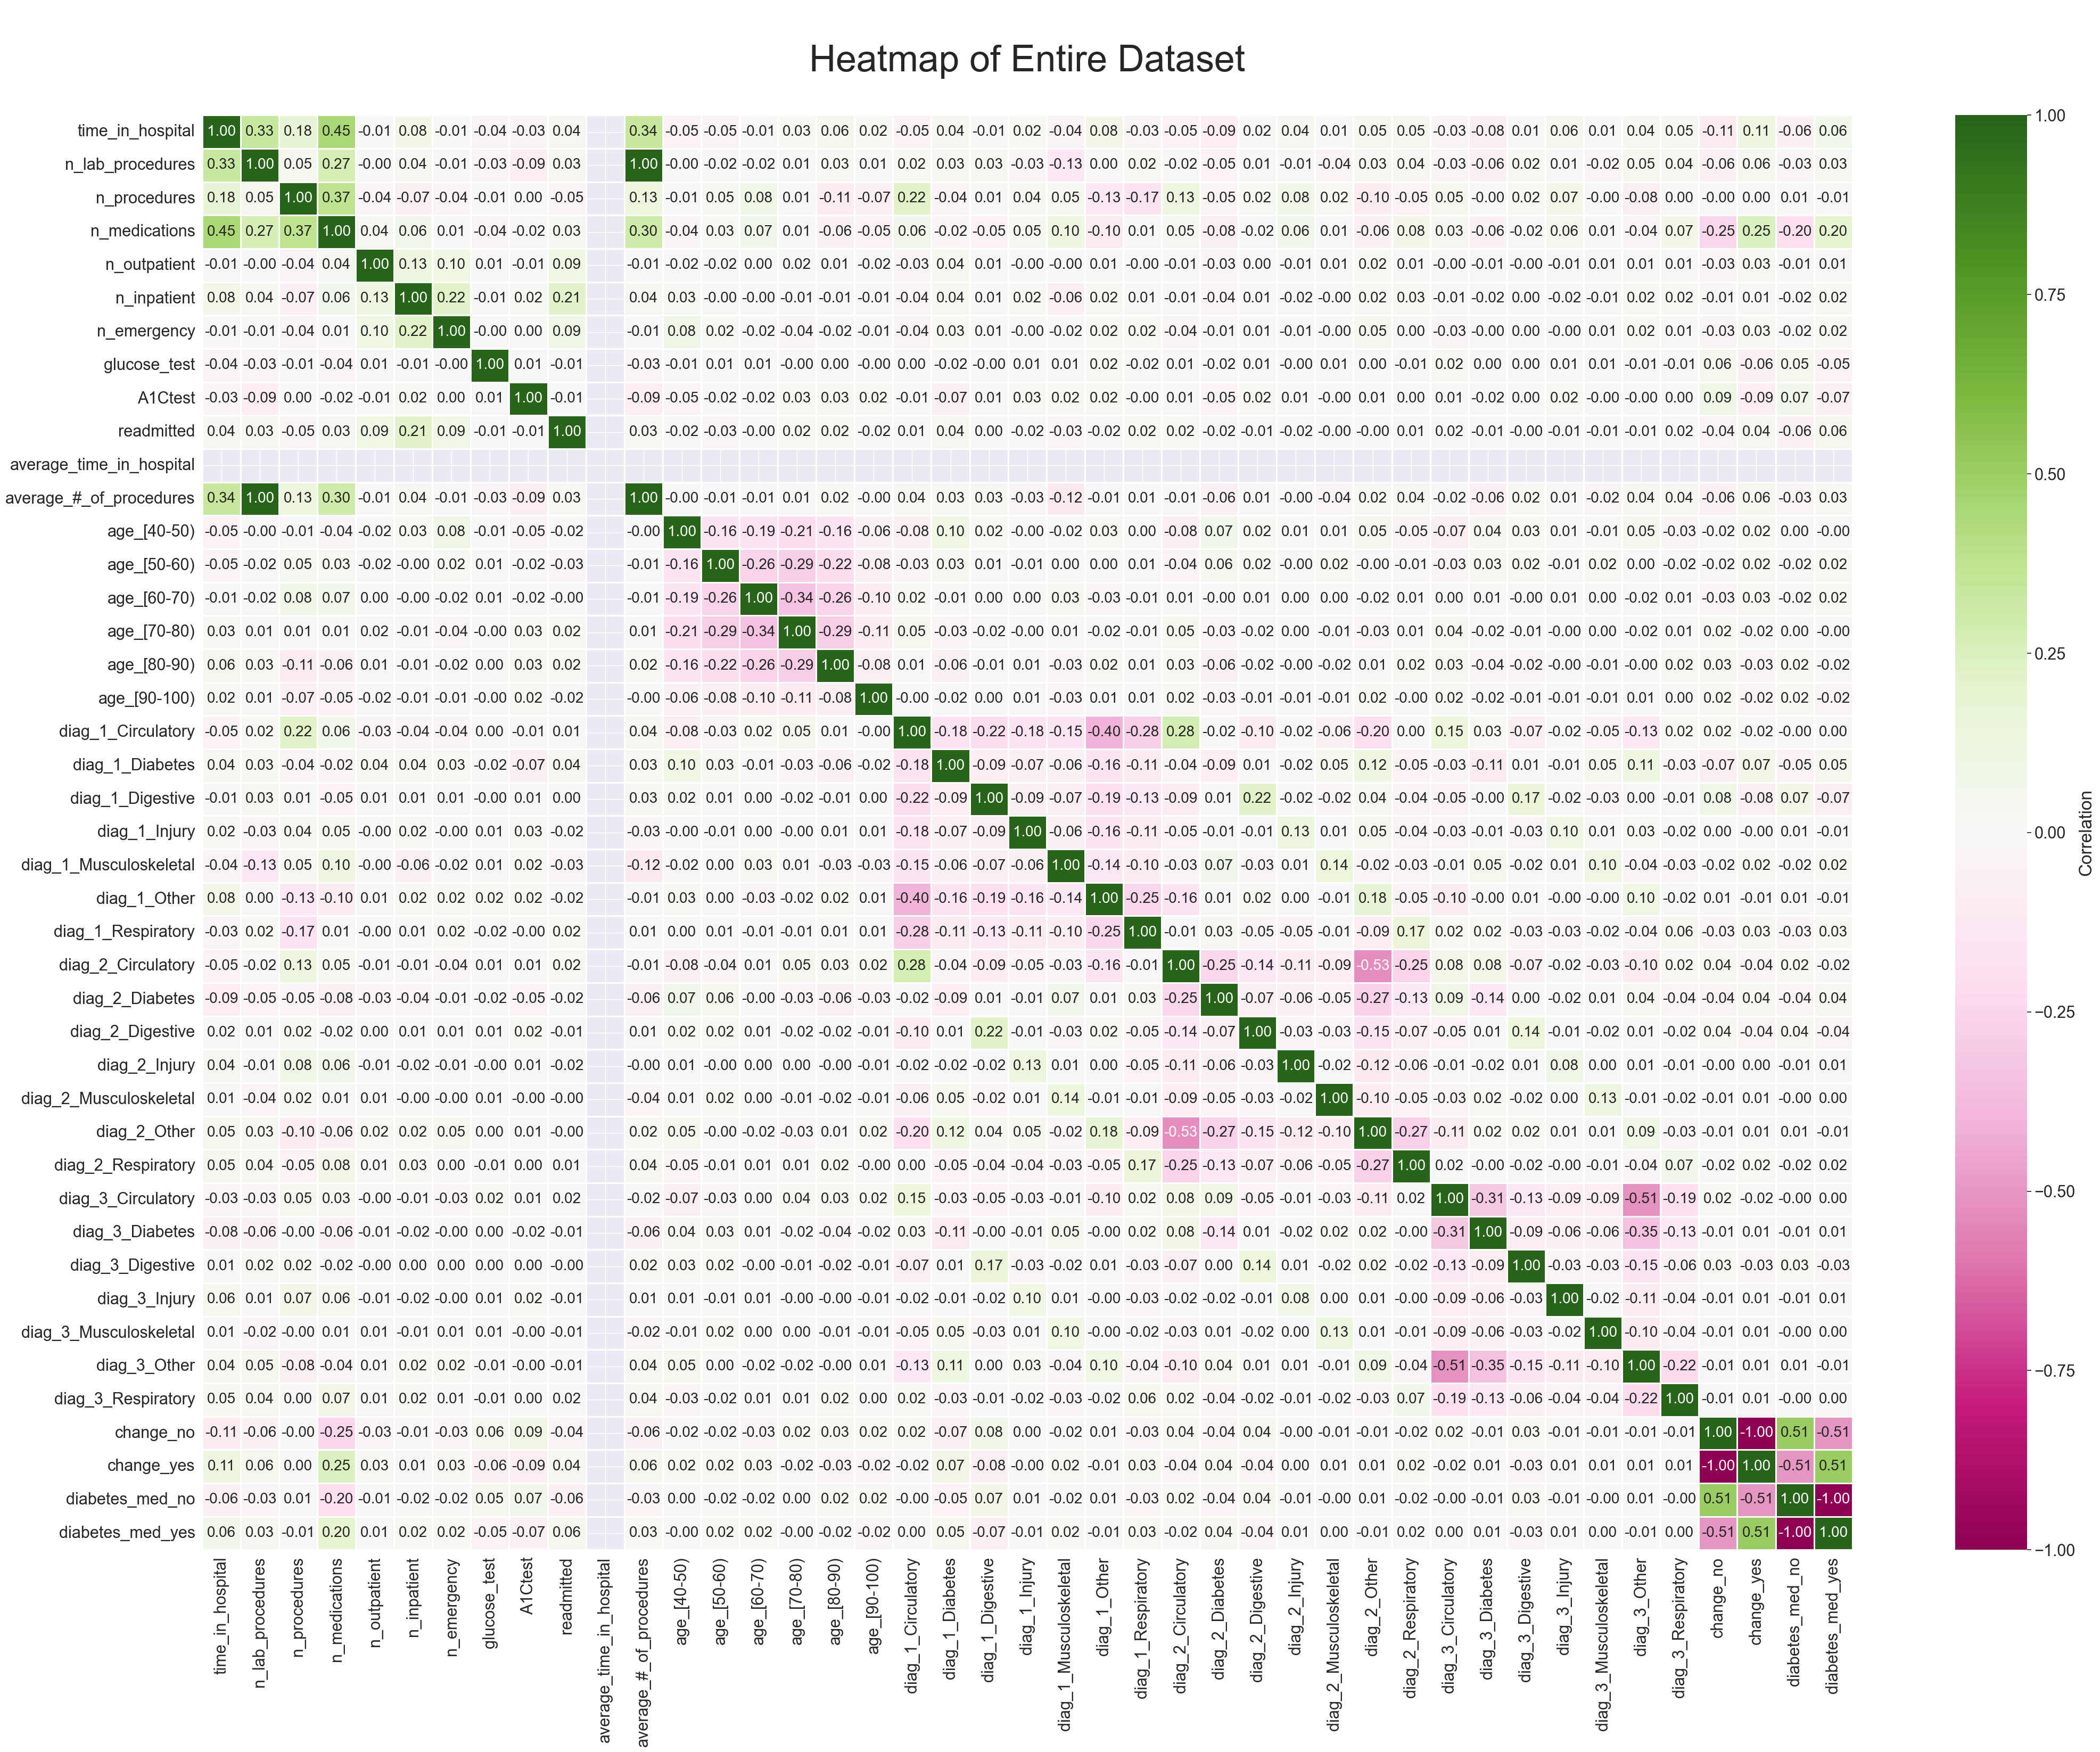

In [77]:
# Creating a heatmap for entire dataset
correlation = Hospital2_df.corr()
sns.set(font_scale=2)
plt.figure(figsize=(50, 35))
ax = sns.heatmap(correlation, annot=True, annot_kws={"size": 20, "ha": "center"}, fmt='.2f', cmap='PiYG', linewidths=2, cbar_kws={'label': 'Correlation'})
plt.title('\nHeatmap of Entire Dataset\n', fontsize=50)
plt.show()

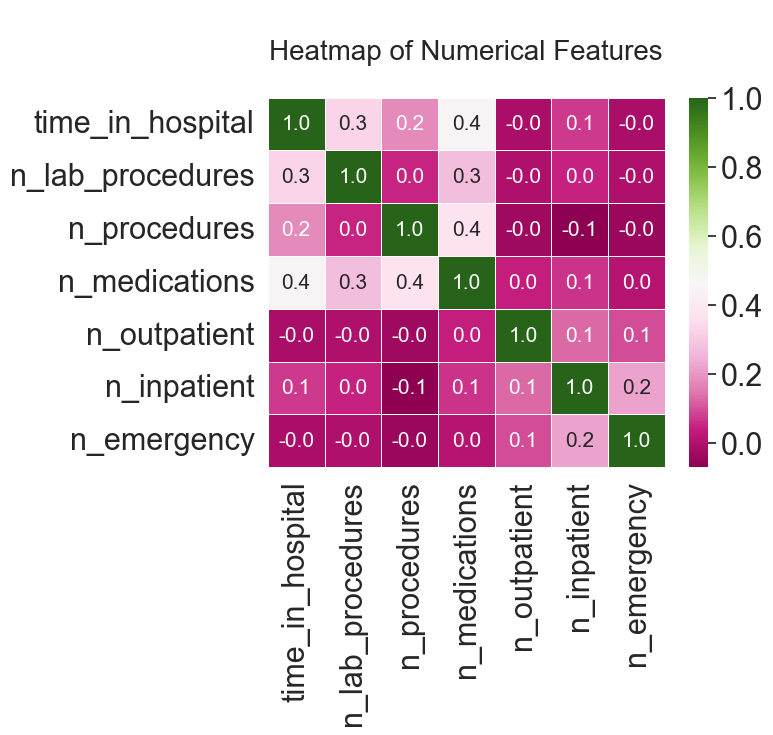

In [89]:
# Creating heatmap for numerical features
numerical_ftrs = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications',
                  'n_outpatient', 'n_inpatient', 'n_emergency']
sns.heatmap(Hospital2_df[numerical_ftrs].corr(), annot=True, annot_kws={"size": 15, "ha": "center"}, cmap='PiYG', linewidth=.5, fmt=".1f")
plt.title('\nHeatmap of Numerical Features\n', fontsize=20)
plt.show()

In [95]:
# Check for missing values
missing_values_table = Hospital2_df.isna().sum().to_frame().rename(columns={0: 'Missing Values'})
missing_values_table = missing_values_table.rename_axis('Features').reset_index()
print("\nTable of Missing Values:\n")
print(missing_values_table)


Table of Missing Values:

                    Features  Missing Values
0           time_in_hospital               0
1           n_lab_procedures               0
2               n_procedures               0
3              n_medications               0
4               n_outpatient               0
5                n_inpatient               0
6                n_emergency               0
7               glucose_test               0
8                    A1Ctest               0
9                 readmitted               0
10  average_time_in_hospital               0
11   average_#_of_procedures               0
12               age_[40-50)               0
13               age_[50-60)               0
14               age_[60-70)               0
15               age_[70-80)               0
16               age_[80-90)               0
17              age_[90-100)               0
18        diag_1_Circulatory               0
19           diag_1_Diabetes               0
20          diag_1_Digestive

In [96]:
# Training the model
features = Hospital2_df.columns[:-1]
x = Hospital2_df[features]
y = Hospital2_df['readmitted']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

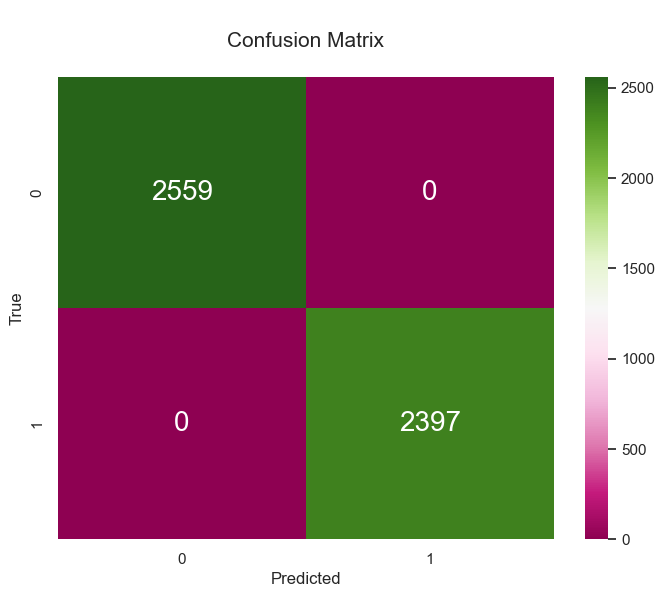

In [106]:
# Confusion Matrix 1
x = Hospital2_df[features]
y = Hospital2_df['readmitted']

x_train2, x_test2, y_train2, y_test2 = train_test_split(x,y, test_size=0.2, random_state=42)
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(x_train2, y_train2)
y_pred2 = model.predict(x_test2)

cm = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 20, "ha": "center"}, cmap='PiYG', fmt='g', cbar=True,)     
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('\nConfusion Matrix\n', fontsize=15)
plt.show()

In [99]:
# Performance Metrix 1
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print('\nPerformance Metrics:\n')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}\n')


Performance Metrics:

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00



In [102]:
# Decision Tree Classifier
# Top 5 most important features
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)

importances = clf.feature_importances_
top_indices = importances.argsort()[::-1][-5:]

top_features = x_train.columns[top_indices]

print("\nTop 5 Most Important Features:\n")
for feature in top_features:
    print(feature,"\n")


Top 5 Most Important Features:

diag_2_Diabetes 

diag_2_Circulatory 

diag_1_Respiratory 

diag_1_Other 

time_in_hospital 



In [103]:
# Descriptive statistics; selected features
selected_features = ['diag_2_Diabetes','diag_2_Circulatory', 'diag_1_Respiratory', 'diag_1_Other','time_in_hospital']
desc_stats_selected = Hospital2_df[selected_features].describe()

print(desc_stats_selected)

       diag_2_Diabetes  diag_2_Circulatory  diag_1_Respiratory  diag_1_Other  \
count     24779.000000        24779.000000        24779.000000  24779.000000   
mean          0.112232            0.327899            0.147746      0.259817   
std           0.315658            0.469457            0.354855      0.438543   
min           0.000000            0.000000            0.000000      0.000000   
25%           0.000000            0.000000            0.000000      0.000000   
50%           0.000000            0.000000            0.000000      0.000000   
75%           0.000000            1.000000            0.000000      1.000000   
max           1.000000            1.000000            1.000000      1.000000   

       time_in_hospital  
count      24779.000000  
mean           4.465354  
std            3.004725  
min            1.000000  
25%            2.000000  
50%            4.000000  
75%            6.000000  
max           14.000000  


<ipython-input-104-6fc89de9d1ea>:13: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.countplot(x=c, hue=c, data=Hospital2_df, palette=custom_palette, legend=False)


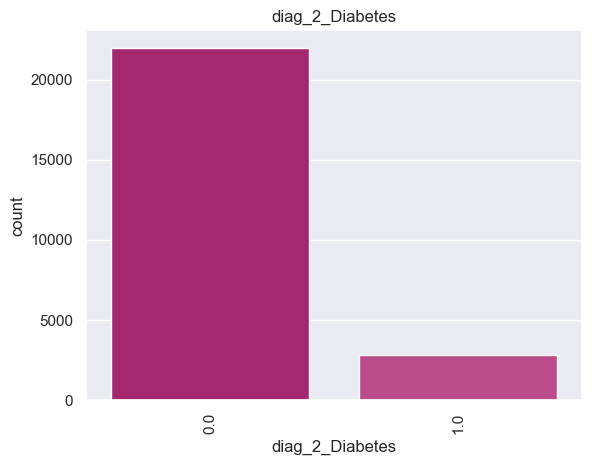

<ipython-input-104-6fc89de9d1ea>:13: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.countplot(x=c, hue=c, data=Hospital2_df, palette=custom_palette, legend=False)


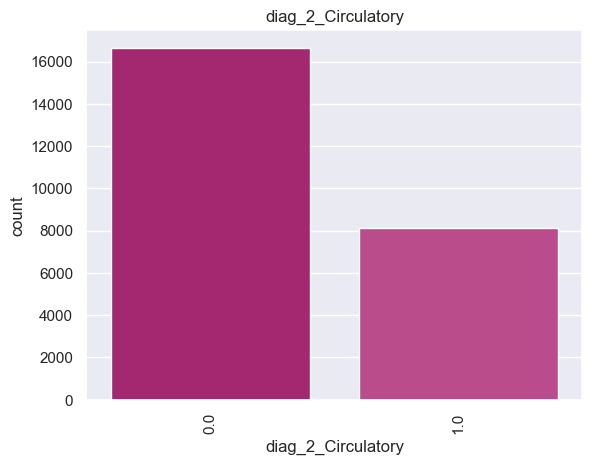

<ipython-input-104-6fc89de9d1ea>:13: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.countplot(x=c, hue=c, data=Hospital2_df, palette=custom_palette, legend=False)


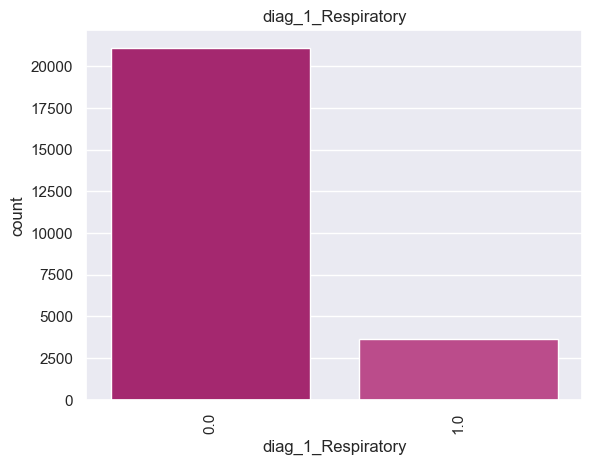

<ipython-input-104-6fc89de9d1ea>:13: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.countplot(x=c, hue=c, data=Hospital2_df, palette=custom_palette, legend=False)


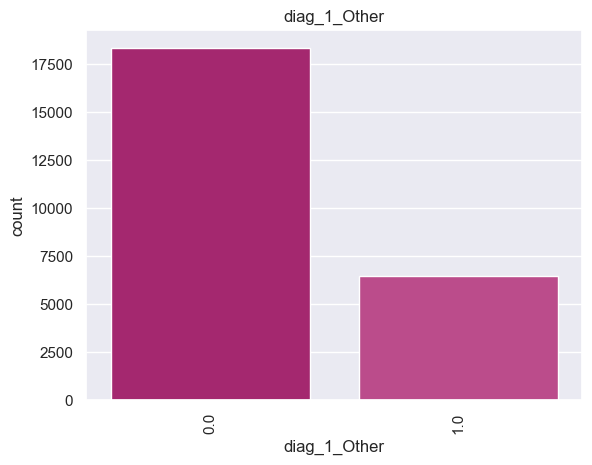

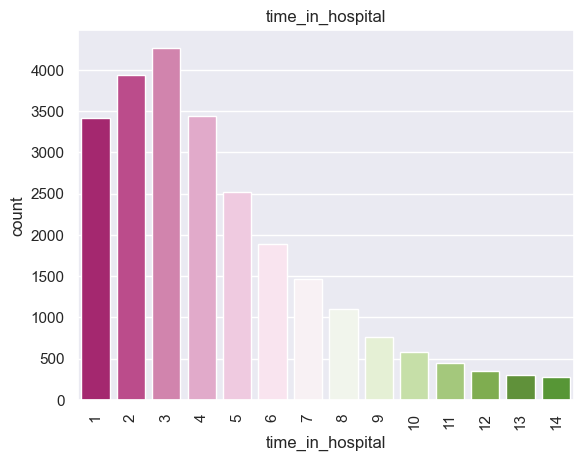

In [104]:
# Graphing selected features
columns = ['diag_2_Diabetes','diag_2_Circulatory','diag_1_Respiratory','diag_1_Other','time_in_hospital']

sns.set(style='darkgrid', font_scale=1)

# Define custom color palette with darker shades of pink and green
custom_palette = sns.color_palette("PiYG", 14)
custom_palette[0] = sns.set_hls_values(custom_palette[0], l=.4)  # Darker pink
custom_palette[-1] = sns.set_hls_values(custom_palette[-1], l=.4)  # Darker green

def plot_cat_count():
    for c in columns:
        sns.countplot(x=c, hue=c, data=Hospital2_df, palette=custom_palette, legend=False)
        plt.title(c)
        plt.xticks(rotation=90)
        plt.show()
plot_cat_count()

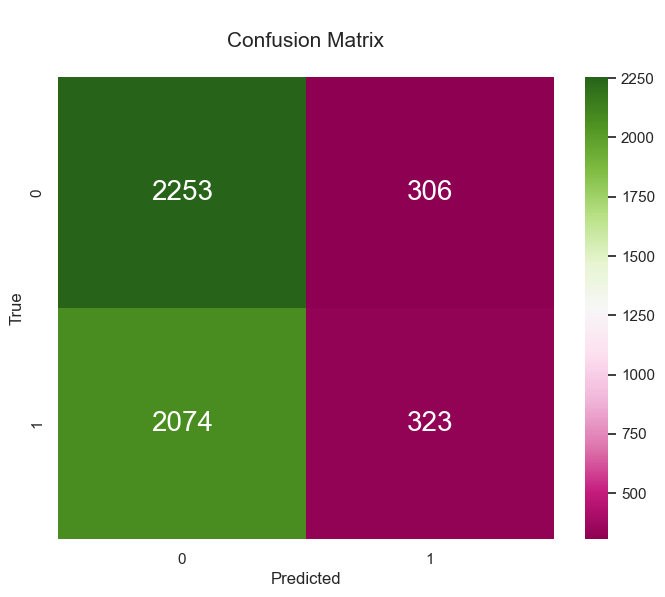

In [107]:
# Confusion Matrix 2
feature_columns2 = ['diag_2_Diabetes',
'diag_2_Circulatory',
'diag_1_Respiratory',
'diag_1_Other',
'time_in_hospital']
x = Hospital2_df[feature_columns2]
y = Hospital2_df['readmitted']

x_train3, x_test3, y_train3, y_test3 = train_test_split(x,y, test_size=0.2, random_state=42)
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(x_train3, y_train3)
y_pred3 = model.predict(x_test3)

cm = confusion_matrix(y_test3, y_pred3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 20, "ha": "center"}, cmap='PiYG', fmt='g', cbar=True,)      
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('\nConfusion Matrix\n', fontsize=15)
plt.show()

In [108]:
# Performance Metrix 2
accuracy1 = (cm[0, 0] + cm[1, 1]) / cm.sum()
precision1 = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall1 = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score1 = 2 * (precision * recall) / (precision + recall)

print('\nPerformance Metrics:\n')
print(f'Accuracy: {accuracy1:.2f}')
print(f'Precision: {precision1:.2f}')
print(f'Recall: {recall1:.2f}')
print(f'F1 Score: {f1_score1:.2f}\n')


Performance Metrics:

Accuracy: 0.52
Precision: 0.51
Recall: 0.13
F1 Score: 1.00



In [110]:
# Define class DLDA
class DLDA(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, train_ftrs, train_tgts):
        self.uniq_tgts = np.unique(train_tgts)
        self.means, self.priors = {}, {}

        self.var  = train_ftrs.var(axis=0) # biased
        for tgt in self.uniq_tgts:
            cases = train_ftrs[train_tgts==tgt]
            self.means[tgt]  = cases.mean(axis=0)
            self.priors[tgt] = len(cases) / len(train_ftrs)
        return self

    def predict(self, test_ftrs):
        disc = np.empty((test_ftrs.shape[0],
                         self.uniq_tgts.shape[0]))
        for tgt in self.uniq_tgts:
            # technically, the maha_dist is sqrt() of this:
            mahalanobis_dists = ((test_ftrs - self.means[tgt])**2 /
                                 self.var)
            disc[:,tgt] = (-np.sum(mahalanobis_dists, axis=1) +
                           2 * np.log(self.priors[tgt]))
        return np.argmax(disc,axis=1)

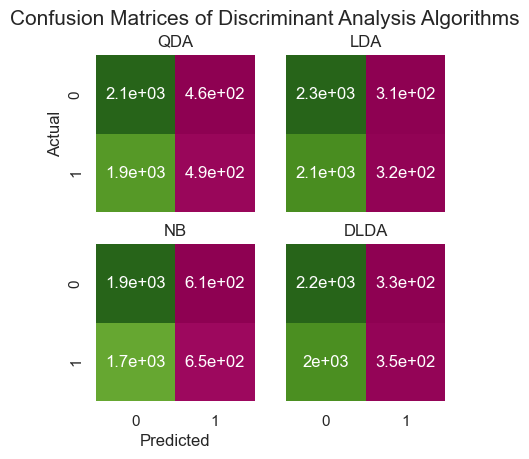

In [112]:
# Discriminant Analysis Algorithm; Confusion Matrices 3
qda  = discriminant_analysis.QuadraticDiscriminantAnalysis()
lda  = discriminant_analysis.LinearDiscriminantAnalysis()
nb   = naive_bayes.GaussianNB()
dlda = DLDA() 

da_methods = [qda, lda, nb, dlda]
names = ["QDA", "LDA", "NB", "DLDA"]
    
fig, axes = plt.subplots(2,2, figsize=(4.5, 4.5),
                         sharex=True, sharey = True)
fig.suptitle("Confusion Matrices of Discriminant Analysis Algorithms\n", fontsize=15)  
for ax, model, name in zip(axes.flat, da_methods, names):
    preds = (model.fit(x_train3, y_train3)
                  .predict(x_test3))
    cm = metrics.confusion_matrix(y_test3, preds)
    sns.heatmap(cm, annot=True, cmap='PiYG', cbar=False, ax=ax)
    ax.set_title(name)

axes[0,0].set_ylabel('Actual')
axes[1,0].set_xlabel('Predicted');

In [113]:
# Performance Metrix 3
accuracy1 = (cm[0, 0] + cm[1, 1]) / cm.sum()
precision1 = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall1 = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score1 = 2 * (precision * recall) / (precision + recall)

print('\nPerformance Metrics:\n')
print(f'Accuracy: {accuracy1:.2f}')
print(f'Precision: {precision1:.2f}')
print(f'Recall: {recall1:.2f}')
print(f'F1 Score: {f1_score1:.2f}\n')


Performance Metrics:

Accuracy: 0.52
Precision: 0.52
Recall: 0.15
F1 Score: 1.00



In [114]:
# Cross Validation; 10-fold
digits = datasets.load_digits()
digits.data
digits.target_names
classifier_parade = \
    {'LogReg(1)' : linear_model.LogisticRegression(max_iter=1000),

     'QDA' : discriminant_analysis.QuadraticDiscriminantAnalysis(),
     'LDA' : discriminant_analysis.LinearDiscriminantAnalysis(),
     'GNB' : naive_bayes.GaussianNB(),
     'DLDA': discriminant_analysis.LinearDiscriminantAnalysis(),
     'DTC' : tree.DecisionTreeClassifier(),
     '5NN-C' : neighbors.KNeighborsClassifier(),
     '10NN-C' : neighbors.KNeighborsClassifier(n_neighbors=10)}

baseline = dummy.DummyClassifier(strategy="uniform")

base_score = skms.cross_val_score(baseline, digits.data, digits.target==1, 
                                  cv=10, scoring='average_precision', n_jobs=-1)

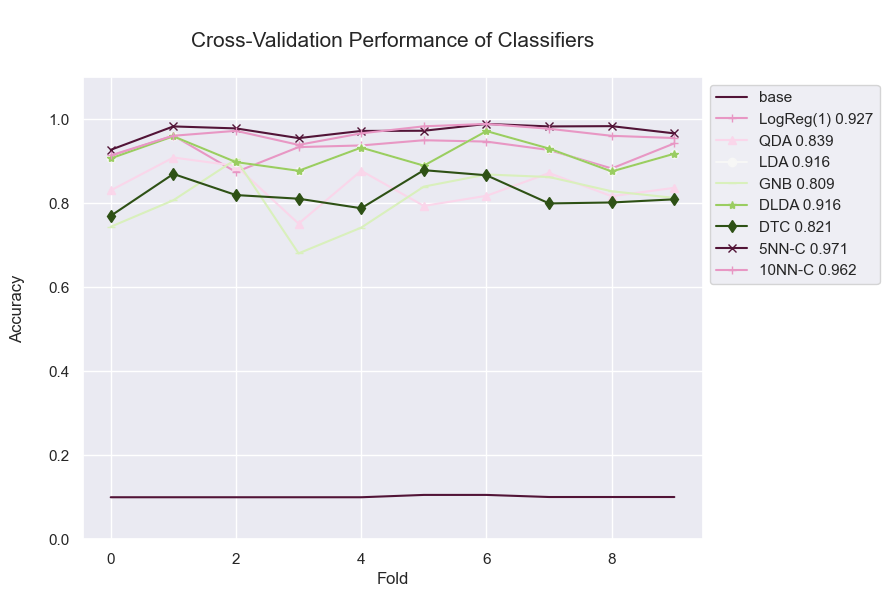

In [120]:
# Cross validation visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Define custom color palette with even darker shades from PiYG
custom_palette = sns.color_palette("PiYG", 7)
custom_palette[0] = sns.set_hls_values(custom_palette[0], l=.2)  # Darkest pink
custom_palette[-1] = sns.set_hls_values(custom_palette[-1], l=.2)  # Darker green
colors = custom_palette.as_hex()

# Plot base with the darkest pink color
ax.plot(base_score, label='base', color=colors[0])

markers = it.cycle(['+', '^', 'o', '_', '*', 'd', 'x'])
for i, (name,model) in enumerate(classifier_parade.items()): 
    cv_scores = skms.cross_val_score(model, 
                                     digits.data, digits.target, 
                                     cv=10, 
                                     scoring='f1_macro', 
                                     n_jobs=-1) 
    my_lbl = "{} {:.3f}".format(name, cv_scores.mean())
    ax.plot(cv_scores, label=my_lbl, marker=next(markers), color=colors[(i + 1) % len(colors)])  # Modulo operation to cycle through colors

ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy\n')
ax.set_title('\nCross-Validation Performance of Classifiers\n', fontsize=15)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
